# Домашнее задание №3
Обучить модель семантической сегментации (человек-vs-фон) на подмножестве датасета MS COCO

In [1]:
# Загрузка библиотек
import os
import skimage.io as io
import numpy as np

import tensorflow as tf
import imageio
import matplotlib.pyplot as plt

### Загрузка данных

In [2]:
!mkdir -p data

!cd data && wget http://images.cocodataset.org/zips/train2017.zip 
!cd data && wget http://images.cocodataset.org/zips/val2017.zip 
!cd data && wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip 

!cd data && unzip -q train2017.zip
!cd data && unzip -q val2017.zip
!cd data && unzip -q annotations_trainval2017.zip

!cd data && git clone https://github.com/cocodataset/cocoapi
!cd data/cocoapi/PythonAPI && make

--2022-08-16 09:28:38--  http://images.cocodataset.org/zips/train2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 54.231.203.65
Connecting to images.cocodataset.org (images.cocodataset.org)|54.231.203.65|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19336861798 (18G) [application/zip]
Saving to: ‘train2017.zip’

train2017.zip       100%[===================>]  18.01G  12.7MB/s    in 25m 8s  

2022-08-16 09:53:47 (12.2 MB/s) - ‘train2017.zip’ saved [19336861798/19336861798]

--2022-08-16 09:53:47--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.198.249
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.198.249|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘val2017.zip’

val2017.zip         100%[===================>] 777.80M  12.3MB/s    in 65s     

2022-08-16 09:54:54 (11.9 MB/s) - 

In [3]:
COCO_ROOT = './data/'
import sys
sys.path.insert(0, os.path.join(COCO_ROOT, 'cocoapi/PythonAPI'))
from pycocotools.coco import COCO

### Подготовка датасетов
1. Универсальный класс Dataset для сегментации

In [4]:
class Dataset():

    def crop_images(self, img, inp_size, random_crop=False):
        shape = tf.shape(img)
        pad = (
            [0, tf.maximum(inp_size - shape[0], 0)],
            [0, tf.maximum(inp_size - shape[1], 0)],
            [0, 0],
        )
        img = tf.pad(img, pad)

        if random_crop:
            img = tf.image.random_crop(img, (inp_size, inp_size, shape[2]))
        else: # central crop
            shape = tf.shape(img)
            ho = (shape[0] - inp_size) // 2
            wo = (shape[1] - inp_size) // 2
            img = img[ho:ho+inp_size, wo:wo+inp_size, :]

        return img

    def train_dataset(self, batch_size, epochs, inp_size):

        def item_to_images(item):
            random_crop = True
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            img_combined = self.crop_images(img_combined, inp_size, random_crop)

            img = tf.cast(img_combined[...,:3], tf.float32) / np.float32(255.)
            mask_class = tf.cast(img_combined[...,3:4], tf.float32)
            return img, mask_class

        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        dataset = dataset.shuffle(buffer_size=len(self.img_list))
        dataset = dataset.map(item_to_images)
        dataset = dataset.repeat(epochs)
        dataset = dataset.batch(batch_size, drop_remainder=True)

        return dataset

    def val_dataset(self, batch_size, inp_size):

        def item_to_images(item):
            random_crop = False
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            img_combined = self.crop_images(img_combined, inp_size, random_crop)

            img = tf.cast(img_combined[...,:3], tf.float32) / np.float32(255.)
            mask_class = tf.cast(img_combined[...,3:4], tf.float32)
            return img, mask_class

        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        dataset = dataset.map(item_to_images)
        dataset = dataset.batch(batch_size, drop_remainder=True)

        return dataset

2. Класс Dataset для сегментационного датасета COCO

In [5]:
class COCO_Dataset(Dataset):

    def __init__(self, sublist):
        ann_file_fpath = os.path.join(COCO_ROOT, 'annotations', 'instances_'+sublist+'2017.json')
        self.coco = COCO(ann_file_fpath)
        self.cat_ids = self.coco.getCatIds(catNms=['person'])
        self.img_list = self.coco.getImgIds(catIds=self.cat_ids)

    def read_images(self, img_id):
        img_id = int(img_id.numpy())
        img_data = self.coco.loadImgs(img_id)[0]
        img_fname = '/'.join(img_data['coco_url'].split('/')[-2:])

        img = io.imread(os.path.join(COCO_ROOT, img_fname))
        if len(img.shape) == 2:
            img = np.tile(img[..., None], (1, 1, 3))

        ann_ids = self.coco.getAnnIds(imgIds=img_data['id'], catIds=self.cat_ids, iscrowd=None)
        anns = self.coco.loadAnns(ann_ids)
        mask_class = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
        for i in range(len(anns)):
            mask_class += self.coco.annToMask(anns[i])
        mask_class = (mask_class > 0).astype(np.uint8)

        img_combined = np.concatenate([img, mask_class[..., None]], axis=2)

        return img_combined

In [6]:
# Создаем датасеты
COCO_dataset_train = COCO_Dataset('train')
COCO_dataset_val = COCO_Dataset('val')

loading annotations into memory...
Done (t=16.21s)
creating index...
index created!
loading annotations into memory...
Done (t=0.51s)
creating index...
index created!


In [7]:
INP_SHAPE = 256

BATCH_SIZE = 16
EPOCHS = 2

train_ds = COCO_dataset_train.train_dataset(BATCH_SIZE, EPOCHS, INP_SHAPE)
val_ds = COCO_dataset_val.val_dataset(BATCH_SIZE, INP_SHAPE)


### Построение и обучение модели UNET

In [9]:
def build_model():
    x = tf.keras.layers.Input((256, 256, 3))
    
    # Conv block 1
    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    out1 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out1)

    # Conv block 2
    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out2 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out2)

    # Conv block 3
    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out3 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out3)

    # Conv block 4
    out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
    out4 = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out4)

    # Добавляем еще 2 свертки: 1 увеличиваем количество каналов, 2 - перемешивает их, достигаем минимума
    out = tf.keras.layers.Conv2D(1024, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(1024, (3, 3), padding='same', activation='relu')(out)

    # Начинаем разворачивать картинку к исходному размеру
    # DeConv block 1 - соединяем с out4 - в каждом 512 каналов
    out = tf.keras.layers.Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out4, out], axis=3)

    # Перемешиваем каналы
    out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)

    # DeConv block 2 - соединяем с out 3 - в каждом 256 каналов
    out = tf.keras.layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out3, out], axis=3)

    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)

    # DeConv block 3 - соединяем с out 2 - в каждом 128 каналов
    out = tf.keras.layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out2, out], axis=3)

    out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)

    # DeConv block 4 - соединяем с out 1 - в каждом 64 канала
    out = tf.keras.layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out1, out], axis=3)

    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)

    # В результате получаем одноканальную карту признаков, применяем активацию сигмоид
    out = tf.keras.layers.Conv2D(1, (3, 3), padding='same', activation='sigmoid')(out)

    return tf.keras.Model(inputs=x, outputs=out)

model = build_model()

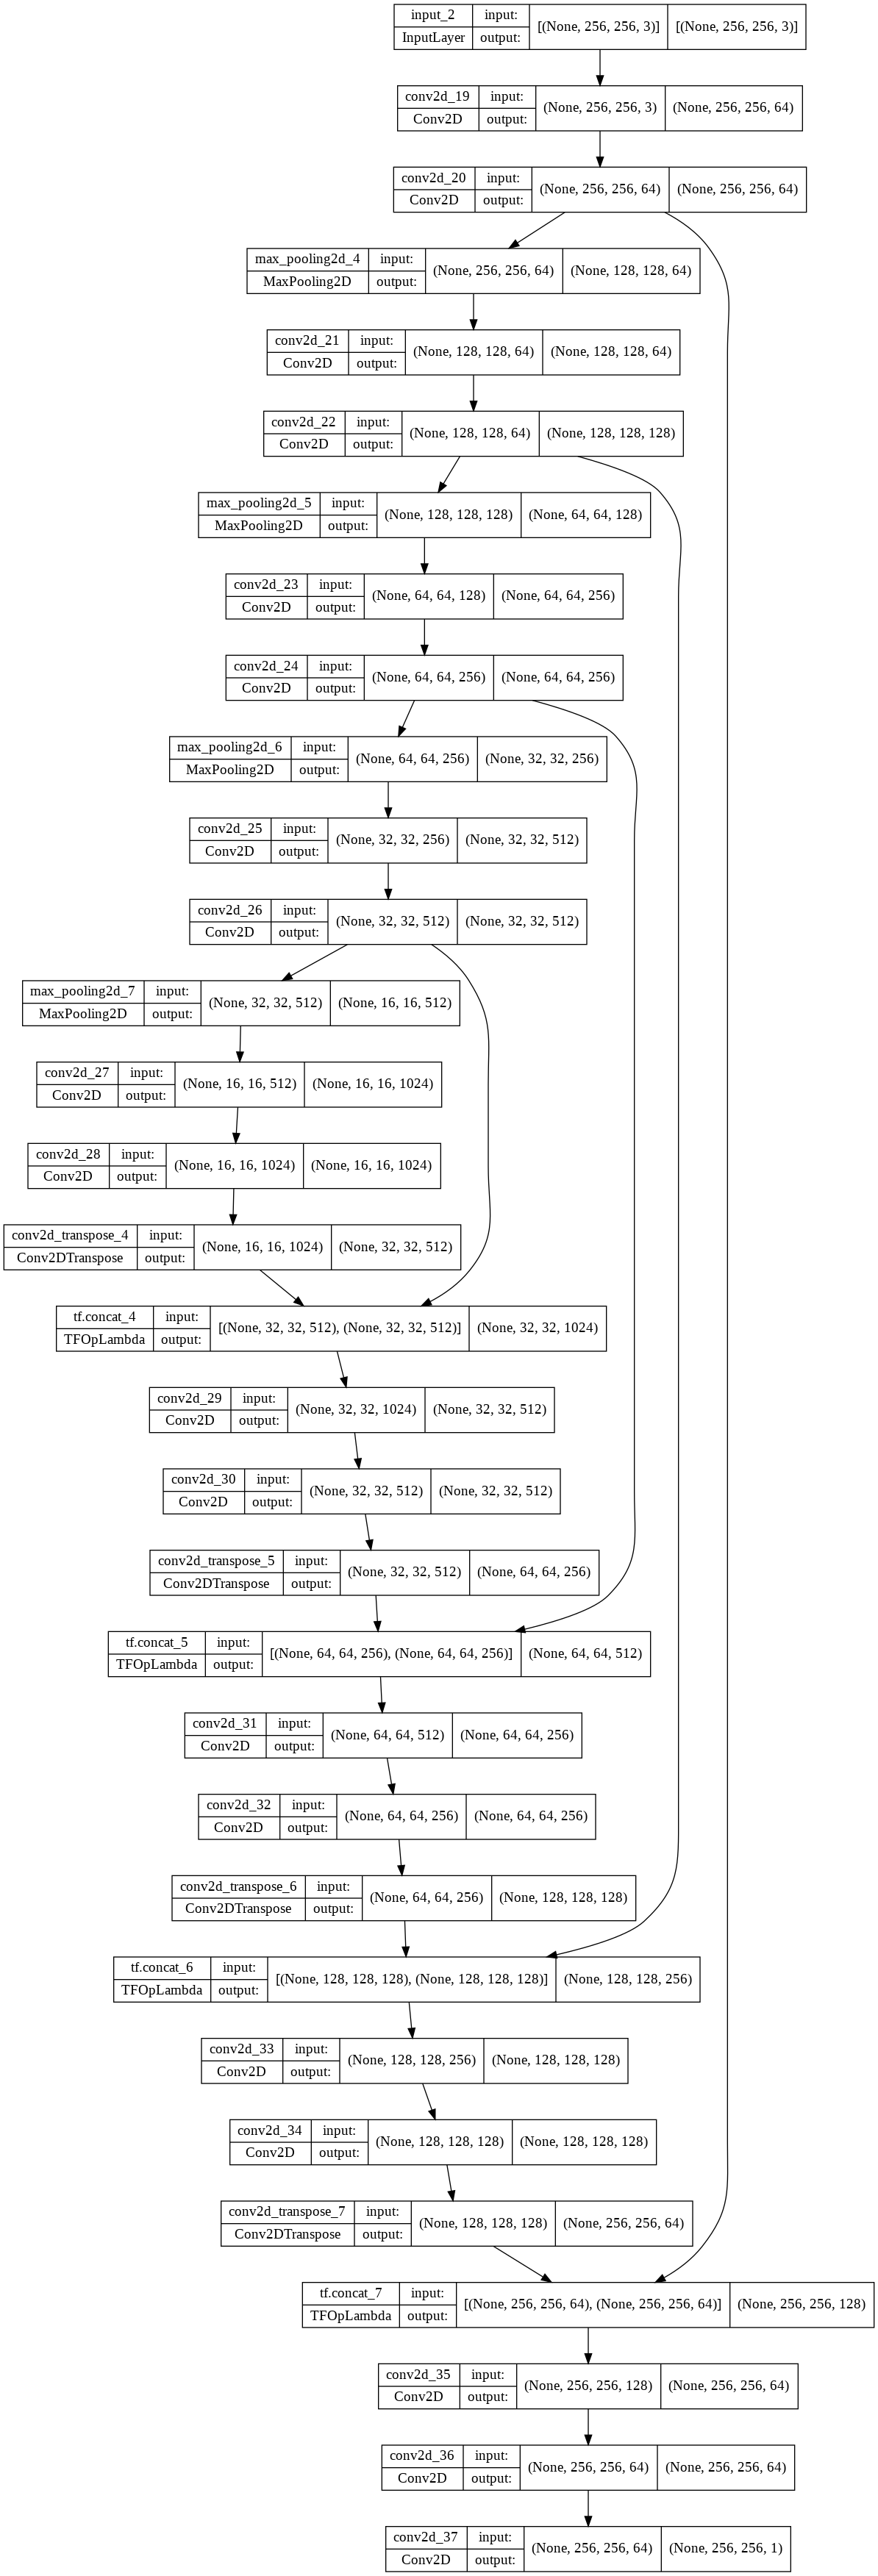

In [10]:
# Визуализация модели
tf.keras.utils.plot_model(model, show_shapes=True)


In [11]:
#Компиляция модели
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics = ['accuracy'])

NUM_EPOCHS = 2

hist = model.fit(train_ds, epochs = NUM_EPOCHS, batch_size = BATCH_SIZE, validation_data = val_ds)

Epoch 1/2
8014/8014 [==============================] - 8553s 1s/step - loss: 0.3880 - accuracy: 0.8192 - val_loss: 0.3211 - val_accuracy: 0.8557
Epoch 2/2
8014/8014 [==============================] - 8511s 1s/step - loss: 0.2823 - accuracy: 0.8747 - val_loss: 0.2833 - val_accuracy: 0.8726


In [12]:
model.evaluate(val_ds)

168/168 [==============================] - 83s 490ms/step - loss: 0.2833 - accuracy: 0.8726


[0.28332820534706116, 0.8726199865341187]

### Оценка работы модели

In [ ]:
# train_x, train_y = next(iter(val_ds))

# pred_prob = model(train_x[:4]).numpy()
# pred_mask = (pred_prob[..., 0] > 0.5).astype(np.float32)

# for i in range(3):
#     plt.figure(figsize=(12, 6))
    
#     plt.subplot(1, 2, 1)
#     plt.title('true')
#     plt.imshow(train_x[i])
#     plt.imshow(train_y[i, ..., 0], alpha=0.5)
#     plt.axis('off')
    
#     plt.subplot(1, 2, 2)
#     plt.title('pred')
#     plt.imshow(train_x[i])
#     plt.imshow(pred_mask[i], alpha=0.5)
#     plt.axis('off')